In [1]:
import scipy.optimize
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import metpy
import scipy.stats as sts
import re
from glob import glob
import warnings
import isca_tools
from isca_tools import cesm
from isca_tools.convection import dry_profile_temp, potential_temp
from isca_tools.convection.base import convection_neutral_profile
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig
from isca_tools.utils.base import weighted_RMS, insert_to_array
from isca_tools.utils import area_weighting, print_ds_var_list
from isca_tools.utils.constants import L_v, c_p, g, R, kappa, lapse_dry
from isca_tools.convection.base import lcl_metpy, lapse_moist, moist_profile
from isca_tools.thesis.lapse_theory import get_bulk_lapse_rate, reconstruct_temp, interp_var_at_pressure, \
    get_var_at_plev, get_ds_in_pressure_range
from isca_tools.thesis.lapse_integral import fitting_2_layer, integral_lapse_dlnp_hydrostatic, get_temp_const_lapse, \
    get_temp_mod_parcel_lapse, get_temp_2_layer_approx, fitting_2_layer_xr
from isca_tools.utils.moist_physics import sphum_sat, moist_static_energy
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory_numerical, get_temp_adiabat_surf, get_temp_adiabat
from isca_tools.thesis.profile_fitting import get_mse_env, get_tropopause_lev_ind, get_mse_prof_rms
from isca_tools.utils.ds_slicing import lat_lon_coord_slice
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from statsmodels.stats.multitest import fdrcorrection
from tqdm.notebook import tqdm
import scipy
from geocat.comp.interpolation import interp_hybrid_to_pressure
import copy
from typing import Tuple, Optional
import os
from sklearn.decomposition import PCA

from isca_tools.utils.xarray import flatten_to_numpy, unflatten_from_numpy, convert_ds_dtypes

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Figure formatting
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7

plt.rc('axes', linewidth=0.5)
plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [3]:
path_ds = '/Users/joshduffield/Desktop/ds_with_parcel_temp.nc'
if not os.path.exists(path_ds):
    from jobs.theory_lapse.scripts.lcl import ds, ds_lcl
else:
    ds = xr.load_dataset(path_ds)

In [4]:
save_unit_test_ds = False
if save_unit_test_ds:
    lat_save = [3, -15, -85, 75, 25, 18, 53]
    lon_save = [15, 320, 100, 320, 50, 0, 100]
    loc_save = ['Congo', 'Amazon', 'Antarctica', 'Greenland', 'PursianGulf', 'Sahara', 'Canada']
    var_save = ['T', 'Z3', 'PS', 'hyam', 'hybm', 'P', 'TREFHT', 'QREFHT', 'ZREFHT', 'PREFHT', 'lnb_ind']
    ds_out = lat_lon_coord_slice(ds, lat_save, lon_save).isel(sample=0, drop=True)[var_save]
    ds_out = ds_out.assign_coords(location=("location", loc_save))
    path_out = '/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/thesis/test/data/ds1.nc'
    if not os.path.exists(path_out):
        ds_out.to_netcdf(path_out)
    else:
        print('File already exists')

In [5]:
# Land masks
invariant_data_path = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/input_data/fv_0.9x1.25_nc3000_Nsw042_Nrs008_Co060_Fi001_ZR_sgh30_24km_GRNL_c170103.nc'
land_frac = xr.open_dataset(invariant_data_path).LANDFRAC
land_frac = land_frac.reindex_like(ds, method="nearest", tolerance=0.01)
lsm = (land_frac > 0)

In [6]:
if not os.path.exists(path_ds):
    ds['mse_REFHT'] = moist_static_energy(ds.TREFHT, ds.QREFHT, ds.ZREFHT)
    ds['p_lcl'], ds['T_lcl_parcel'] = lcl_metpy(ds.TREFHT, ds.QREFHT, ds.PREFHT)
    ds['T_lcl_env'] = get_var_at_plev(ds.T, ds.P, ds.p_lcl)
# ds['mse_env'] = get_mse_env(ds.T, ds.P, ds.Z3, ds.p_lcl, sphum_below_lcl=ds.QREFHT)

In [7]:
if not os.path.exists(path_ds):
    p_ft = 400 * 100
    ds['T_ft_env'] = interp_hybrid_to_pressure(ds.T, ds.PS, ds.hyam, ds.hybm, ds.P0, np.atleast_1d(p_ft), lev_dim='lev')
    ds['T_ft_env'].load()
    ds['Z_ft_env'] = interp_hybrid_to_pressure(ds.Z3, ds.PS, ds.hyam, ds.hybm, ds.P0, np.atleast_1d(p_ft),
                                               lev_dim='lev')
    ds['Z_ft_env'].load()
    ds['mse_ft_env_sat'] = moist_static_energy(ds.T_ft_env, sphum_sat(ds.T_ft_env, p_ft), ds.Z_ft_env)
else:
    p_ft = float(ds.plev)

In [8]:
if not os.path.exists(path_ds):
    # Compute parcel temperature at p_ft
    pbar = tqdm(total=ds.lon.size * ds.sample.size)
    temp_ft_parcel = []
    for i in range(ds.lon.size):
        var_samp = []
        for j in range(ds.sample.size):
            ds_use = ds.isel(lon=i, sample=j)
            var = get_temp_adiabat(flatten_to_numpy(ds_use.TREFHT), flatten_to_numpy(ds_use.QREFHT),
                                   flatten_to_numpy(ds_use.PREFHT), p_ft)
            var_samp.append(unflatten_from_numpy(var, ds_use.TREFHT))
            pbar.update(1)
        temp_ft_parcel.append(xr.concat(var_samp, dim=ds.sample))
    ds['T_ft_parcel'] = xr.concat(temp_ft_parcel, dim=ds.lon)

In [9]:
def get_temp_surf_parcel_from_lcl_env(temp_surf, p_surf, p_lcl, temp_lcl_env):
    # Given the environmental temperature at the LCL, this computes the surface temperature a parcel would have to
    # start from to reach that temperature at the LCL
    lapse_env = get_bulk_lapse_rate(temp_surf, temp_lcl_env, p_surf, p_lcl)
    param = (1 - lapse_env / lapse_dry) * lapse_dry * R / g
    return temp_surf * (p_surf / p_lcl) ** param


if not os.path.exists(path_ds):
    ds['TREFHT_parcel_from_lcl'] = get_temp_surf_parcel_from_lcl_env(ds.TREFHT, ds.PREFHT, ds.p_lcl, ds.T_lcl_env)
    pbar = tqdm(total=ds.lon.size * ds.sample.size)
    temp_ft_parcel = []
    for i in range(ds.lon.size):
        var_samp = []
        for j in range(ds.sample.size):
            ds_use = ds.isel(lon=i, sample=j)
            var = get_temp_adiabat(flatten_to_numpy(ds_use['TREFHT_parcel_from_lcl']),
                                   flatten_to_numpy(ds_use.QREFHT), flatten_to_numpy(ds_use.PREFHT), p_ft)
            var_samp.append(unflatten_from_numpy(var, ds_use.TREFHT))
            pbar.update(1)
        temp_ft_parcel.append(xr.concat(var_samp, dim=ds.sample))
    ds['T_ft_parcel2'] = xr.concat(temp_ft_parcel,
                                   dim=ds.lon)  # FT temp a parcel would reach if rising from environmental temp at LCL

In [10]:
save_processed = False
ds = convert_ds_dtypes(ds, verbose=True)
comp_level = 4
if (not os.path.exists(path_ds)) and save_processed:
    ds.to_netcdf(path_ds, format="NETCDF4",
                 encoding={var: {"zlib": True, "complevel": comp_level} for var in ds.data_vars})
    print(f'Saved Dataset to {path_ds}')

### Valid Regions
To analyse whether an environmental temperature profile is convectively neutral, we need a significant number of model levels in both the layers: Surface to LCL & LCL to FT level.

Here, we plot regions which satisfy both these requirements.

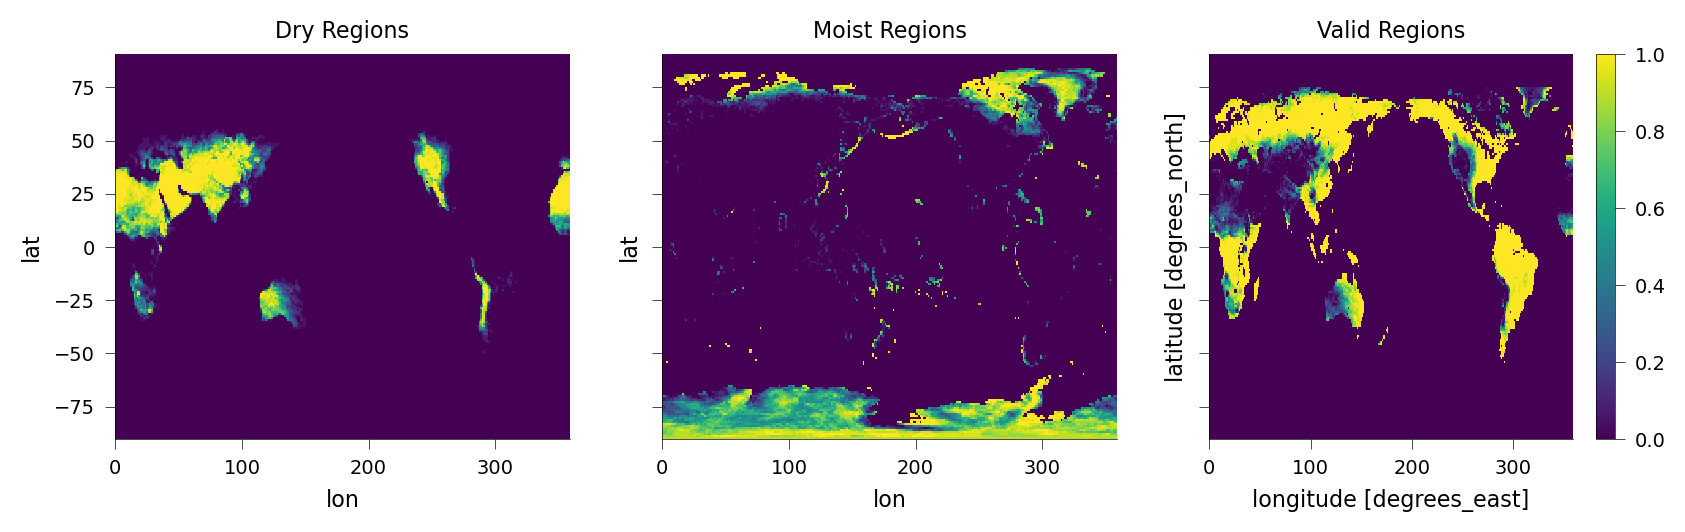

In [11]:
# Dry if 2 or fewer model levels between LCL and FT
dry_lev_thresh = 2
p_range = (ds.P >= p_ft) & (ds.P < ds.p_lcl)
dry_mask = p_range.sum(dim='lev') <= dry_lev_thresh

# Moist if 2 or fewer model levels between REFHT and LCL (not including REFHT)
moist_lev_thresh = 2
p_range = (ds.P >= ds.p_lcl) & (ds.P < ds.PREFHT)
moist_mask = p_range.sum(dim='lev') <= moist_lev_thresh

land_frac_thresh = 0.9
lat_valid_lims = [-60, 75]
valid = (land_frac > land_frac_thresh) & (~dry_mask) & (~moist_mask) & (ds.lat > lat_valid_lims[0]) & (
        ds.lat < lat_valid_lims[1])

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig_resize(fig, 10)
(dry_mask.where(lsm).sum(dim='sample') / ds.sample.size).isel(co2=0).plot(ax=ax[0], add_colorbar=False)
(moist_mask.where(lsm).sum(dim='sample') / ds.sample.size).isel(co2=0).plot(ax=ax[1], add_colorbar=False)
(valid.where(lsm).sum(dim='sample') / ds.sample.size).isel(co2=0).plot(ax=ax[2])
ax[0].set_title('Dry Regions')
ax[1].set_title('Moist Regions')
ax[2].set_title('Valid Regions')
plt.show()

### Decompose simple CAPE into lapse rate responses
Below I look at the variation of the quantity $\epsilon = MSE_s - MSE_{FT}^*$ which should be zero for a convectively neutral profiles into contributions from how the lapse rate differs from the parcel profile below and above the LCL.

* $\Gamma_{env, D} = \eta_D \Gamma_D$ is the profile below the LCL (env is environmental, and $\Gamma_D$ is the dry adiabatic lapse rate)
* $\Gamma_{env, M} = \eta_M \Gamma_M$ is the profile above the LCL (env is environmental, and $\Gamma_M$ is adiabat is the bulk moist adiabatic lapse rate)

Below we see that on average, $\epsilon \approx 0$, and that $\epsilon$ increases with warming, maybe corresponding to an increase in CAPE.

In [12]:
ds.attrs['lapse_below_parcel'] = lapse_dry * 1000
ds['lapse_below_env'] = get_bulk_lapse_rate(ds.TREFHT, ds.T_lcl_env, ds.PREFHT, ds.p_lcl) * 1000
ds['lapse_above_env'] = get_bulk_lapse_rate(ds.T_lcl_env, ds.T_ft_env.isel(plev=0), ds.p_lcl, p_ft) * 1000
ds['lapse_above_parcel'] = get_bulk_lapse_rate(ds.T_lcl_parcel, ds.T_ft_parcel, ds.p_lcl,
                                               p_ft) * 1000  # from parcel LCL following moist adiabat
ds['lapse_above_parcel2'] = get_bulk_lapse_rate(ds.T_lcl_env, ds.T_ft_parcel2, ds.p_lcl,
                                                p_ft) * 1000  # from env LCL following moist adiabat

In [13]:
def get_invariant_variance_indicator(var, valid):
    # useful measure of variation in a variable independent of units - can compare across variables with different magnitude and dimensions
    var = var - var.where(valid).median()  # make centered around 0
    var = np.abs(var)  # get absolute deviation from median
    # return IQR divided by median
    return (var.where(valid).quantile(0.75) - var.where(valid).quantile(0.25)) / var.where(valid).median()

1.3176
1.3326


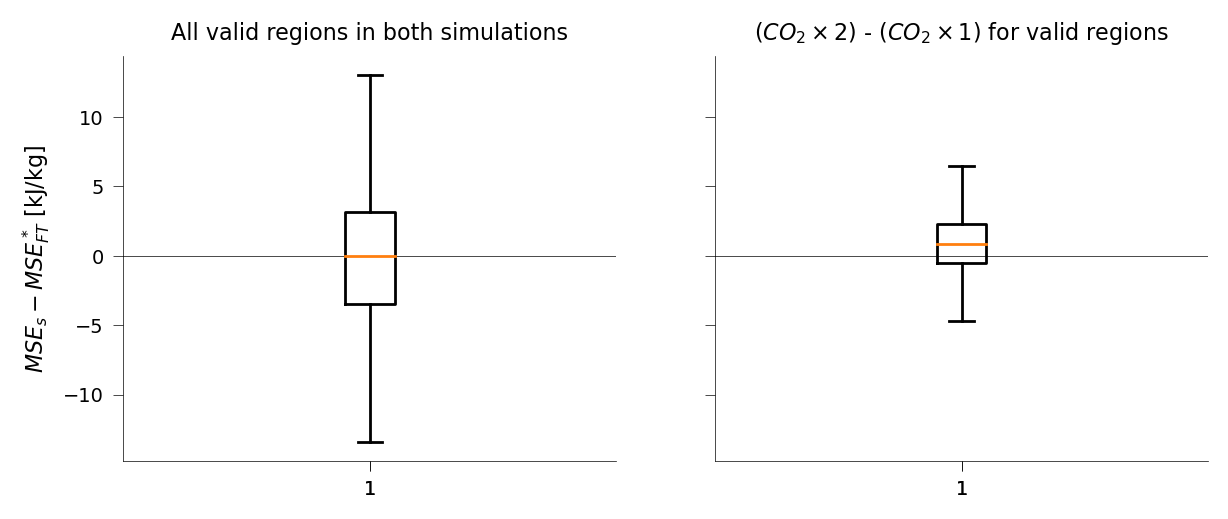

In [14]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
var = ds.mse_REFHT - ds.mse_ft_env_sat.isel(plev=0)
ax[0].boxplot(flatten_to_numpy(var.transpose(*valid.dims))[flatten_to_numpy(valid & ~np.isnan(valid))], widths=0.1,
              showfliers=False)
print(f"{get_invariant_variance_indicator(var, valid):.4f}")  # print indicator of variation
valid_all = valid.sum(dim=['sample', 'co2']) == ds.sample.size * ds.co2.size
var = var.isel(co2=1).where(valid_all).mean(dim='sample') - var.isel(co2=0).where(valid_all).mean(dim='sample')
print(f"{get_invariant_variance_indicator(var, valid):.4f}")  # print indicator of variation
ax[1].boxplot(flatten_to_numpy(var.transpose(*valid_all.dims))[flatten_to_numpy(valid_all & ~np.isnan(valid_all))],
              widths=0.1, showfliers=False)
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_title('All valid regions in both simulations')
ax[1].set_title(f'($CO_2 \\times {ds.co2.values[1]:.0f}$) - ($CO_2 \\times {ds.co2.values[0]:.0f}$) for valid regions')
ax[0].set_ylabel('$MSE_s - MSE_{FT}^*$ [kJ/kg]')
plt.show()

### Lapse Rate boxplots
Below we see that on average, $\eta_D < 1$ so that below the LCL, the lapse rate is not as large as the dry adiabat, so reach LCL at a warmer temperature than the parcel. This corresponds to CIN generation.

Above the LCL, I plot two values of $\eta_M$. White starts from parcel temperature at LCL. Gray starts from environmental temperature at LCL. Seen as the environmental temperature at the LCL is larger than the parcel temperature, and that the moist adiabatic lapse rate is smaller at hotter temperatures, we see the expected effect that for this second method, $\eta_{M}$ is smaller.

The second method has the advantage that both $\eta_{M} \approx 0$ and $\delta \eta{M} \approx 0$. These being the naive expectations of a convectively neutral profile.

1.1814
1.3996
1.3180
1.2972
1.3002
1.2901


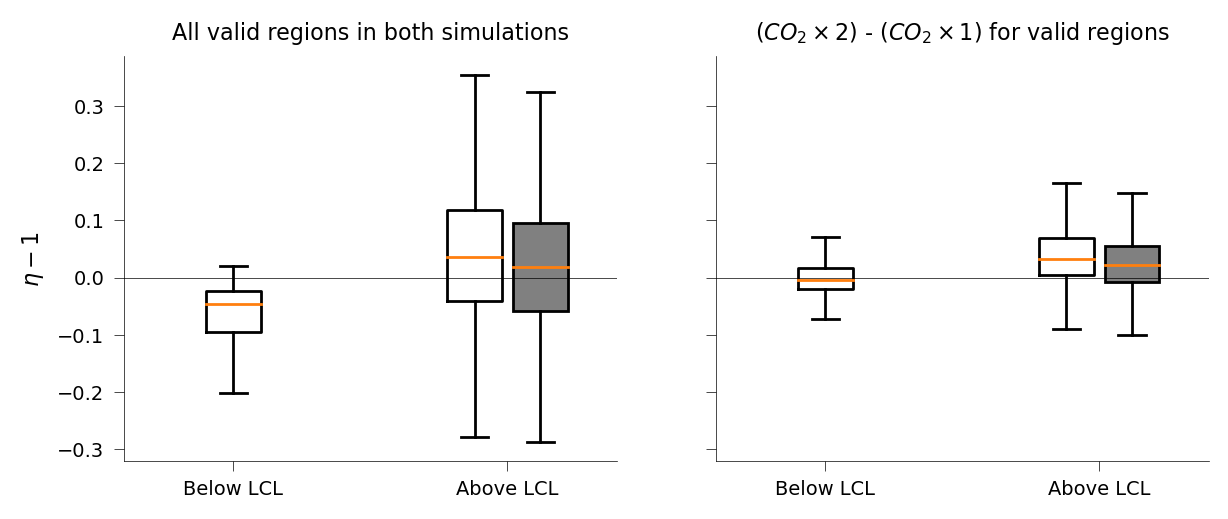

In [15]:
valid_use = valid.sum(dim=['sample', 'co2']) == ds.sample.size * ds.co2.size
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, 7)
var = [ds['lapse_below_env'] / ds.attrs['lapse_below_parcel'], ds['lapse_above_env'] / ds['lapse_above_parcel'],
       ds['lapse_above_env'] / ds['lapse_above_parcel2']]
x_pos = [1, 1.5 - 0.06, 1.5 + 0.06]
for i in range(len(x_pos)):
    ax[0].boxplot(flatten_to_numpy(var[i].transpose(*valid.dims))[flatten_to_numpy(valid & ~np.isnan(valid))] - 1,
                  widths=0.1, showfliers=False,
                  positions=[x_pos[i]], patch_artist=i == 2, boxprops=dict(facecolor='gray') if i == 2 else None)
    print(f"{get_invariant_variance_indicator(var[i], valid):.4f}")
    var_use = var[i].isel(co2=1).where(valid_all).mean(dim='sample') - var[i].isel(co2=0).where(valid_all).mean(
        dim='sample')
    ax[1].boxplot(
        flatten_to_numpy(var_use.transpose(*valid_all.dims))[flatten_to_numpy(valid_all & ~np.isnan(valid_all))],
        widths=0.1, showfliers=False,
        positions=[x_pos[i]], patch_artist=i == 2, boxprops=dict(facecolor='gray') if i == 2 else None)
    print(f"{get_invariant_variance_indicator(var_use, valid_all):.4f}")

ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xticks([1, 1.5])
ax[0].set_xticklabels(['Below LCL', 'Above LCL'])
ax[0].set_xlim(0.8, 1.7)
ax[0].set_title('All valid regions in both simulations')
ax[1].set_title(f'($CO_2 \\times {ds.co2.values[1]:.0f}$) - ($CO_2 \\times {ds.co2.values[0]:.0f}$) for valid regions')
ax[0].set_ylabel('$\eta - 1$')
plt.show()

### Spatial Distribution of CAPE proxies
Below we see that the spatial variation in $\eta_M$ and $\epsilon$ are very similar. This is the case for the climatology and the changes.

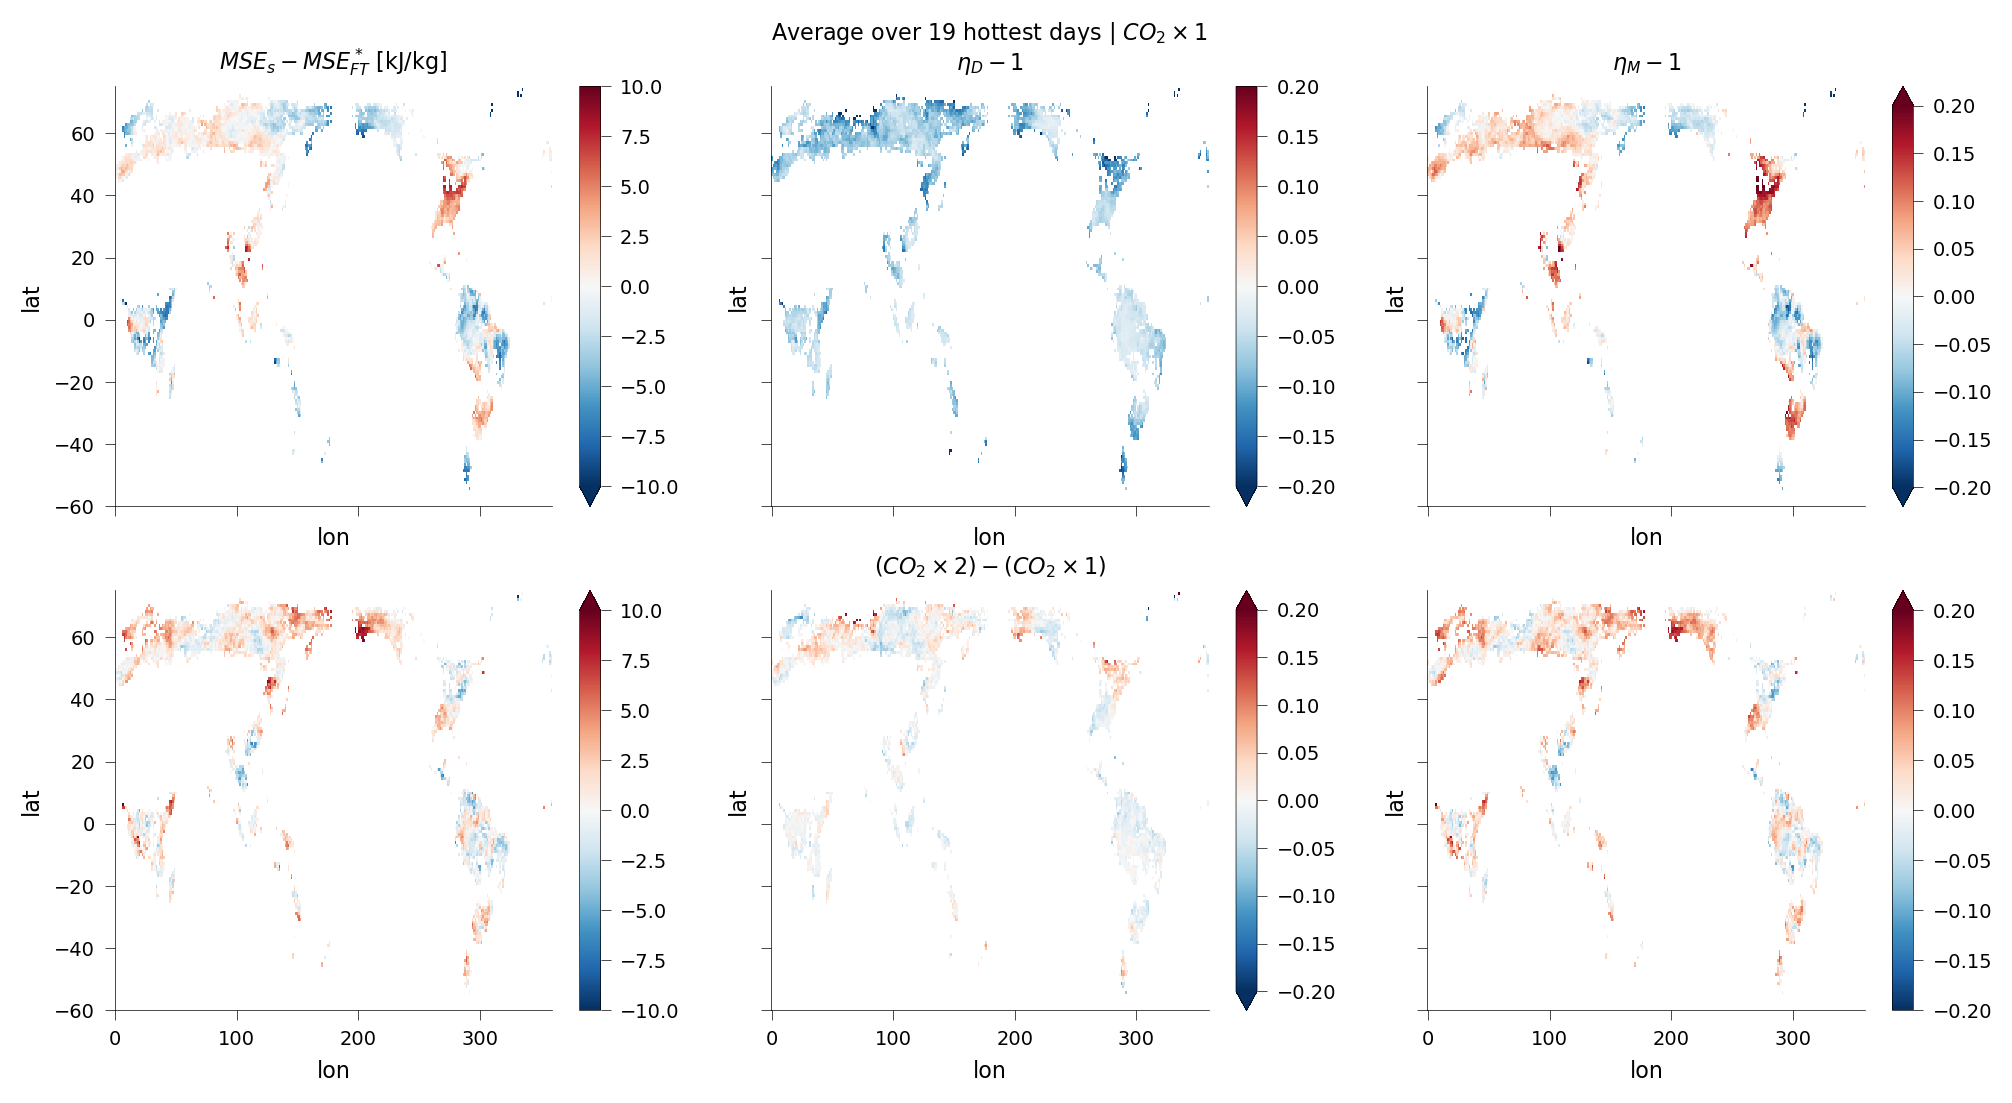

In [16]:
mask_plot = valid_all
# mask_plot = lsm
fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig_resize(fig, 12)
var = ds.mse_REFHT - ds.mse_ft_env_sat.isel(plev=0)
var.where(mask_plot).isel(co2=0).mean(dim='sample').plot(ax=ax[0, 0], vmin=-10)
(var.isel(co2=1).mean(dim='sample') - var.isel(co2=0).mean(dim='sample')).where(mask_plot).plot(ax=ax[1, 0], vmin=-10)

var = ds['lapse_below_env'] / ds.attrs['lapse_below_parcel'] - 1
im = var.where(mask_plot).isel(co2=0).mean(dim='sample').plot(ax=ax[0, 1], vmax=0.2)
im.colorbar.set_label('')
im = (var.isel(co2=1).mean(dim='sample') - var.isel(co2=0).mean(dim='sample')).where(mask_plot).plot(ax=ax[1, 1],
                                                                                                     vmax=0.2)
im.colorbar.set_label('')

var = ds['lapse_above_env'] / ds['lapse_above_parcel2'] - 1
var.where(mask_plot).isel(co2=0).mean(dim='sample').plot(ax=ax[0, 2], vmax=0.2)
(var.isel(co2=1).mean(dim='sample') - var.isel(co2=0).mean(dim='sample')).where(mask_plot).plot(ax=ax[1, 2], vmin=-0.2)

ax[0, 0].set_ylim(lat_valid_lims[0], lat_valid_lims[1])

ax[0, 0].set_title('$MSE_s - MSE_{FT}^*$ [kJ/kg]')
ax[0, 1].set_title('$CO_2 \\times 1$\n$\eta_{D} - 1$')
ax[0, 1].set_title(
    f'Average over {ds.sample.size} hottest days | $CO_2 \\times {ds.co2.values[0]:.0f}$\n''$\eta_{D} - 1$')
ax[0, 2].set_title('$\eta_{M} - 1$')
ax[1, 1].set_title(f'$(CO_2 \\times {ds.co2.values[1]:.0f}) - (CO_2 \\times {ds.co2.values[0]:.0f})$')
ax[1, 0].set_title('')
plt.show()

### Change in $\eta_{M}$ with warming
Above, it looks like the regions with the largest change in CAPE, or $\eta_{M}$ have large negative $\eta_{M}-1$ in the current climate. Below I do a plot to check this, but it does not appear that this is a robust trend.

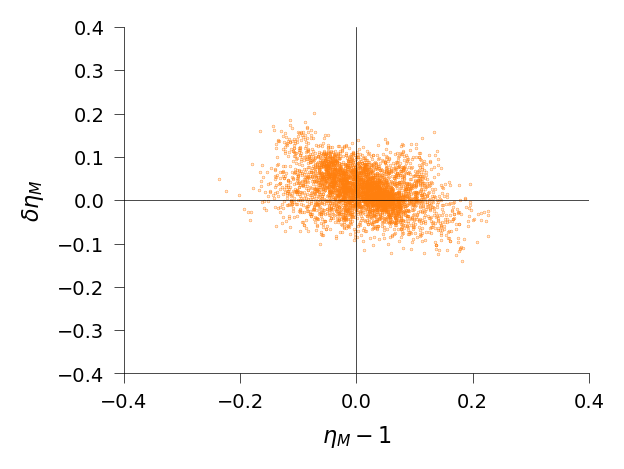

In [17]:
var = ds['lapse_above_env'] / ds['lapse_above_parcel2'] - 1
var = var.mean(dim='sample')
fig, ax = plt.subplots(1, 1)
fig_resize(fig, 3)
# plt.scatter(var.isel(co2=0).where(lsm & ~valid_all), (var.isel(co2=1) - var.isel(co2=0)).where(lsm & ~valid_all), s=1, alpha=0.5, marker='.')
ax.scatter(var.isel(co2=0).where(valid_all), (var.isel(co2=1) - var.isel(co2=0)).where(valid_all), s=0.1, marker='.',
           color='C1')
ax.set_xlim(-0.4, 0.4)
ax.set_ylim(-0.4, 0.4)
ax.set_xlabel('$\eta_{M}-1$')
ax.set_ylabel('$\delta \eta_{M}$')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.axvline(0, color='k', lw=ax_linewidth)
plt.show()

### Interpretation with $\epsilon$ replaced by $\eta$
One advantage of replacing with $\eta$ is that it changes the quantification of the physical mechanisms to account for the fact the lapse rates are not equal to the adiabatic lapse rates.

Some plots are shown to emphasize this below, with logic as follows
* East Canada shows very large warming in surface temperature
* This region also shows a large reduction in surface relative humidity with warming
* This region also has $\eta_{M} < 1$ in the current climate. This means in the current climate, the lapse rate difference between below the LCL and above the LCL is even greater than that expected by an SQE profile. Thus, a reduction in relative humidity with no change in $\eta_M$ would have an enhanced surface warming effect, than the SQE case with $\eta_M=0$.
* This means the relative humidity change mechanism would have an extra contribution due to $\eta_{M} < 1$

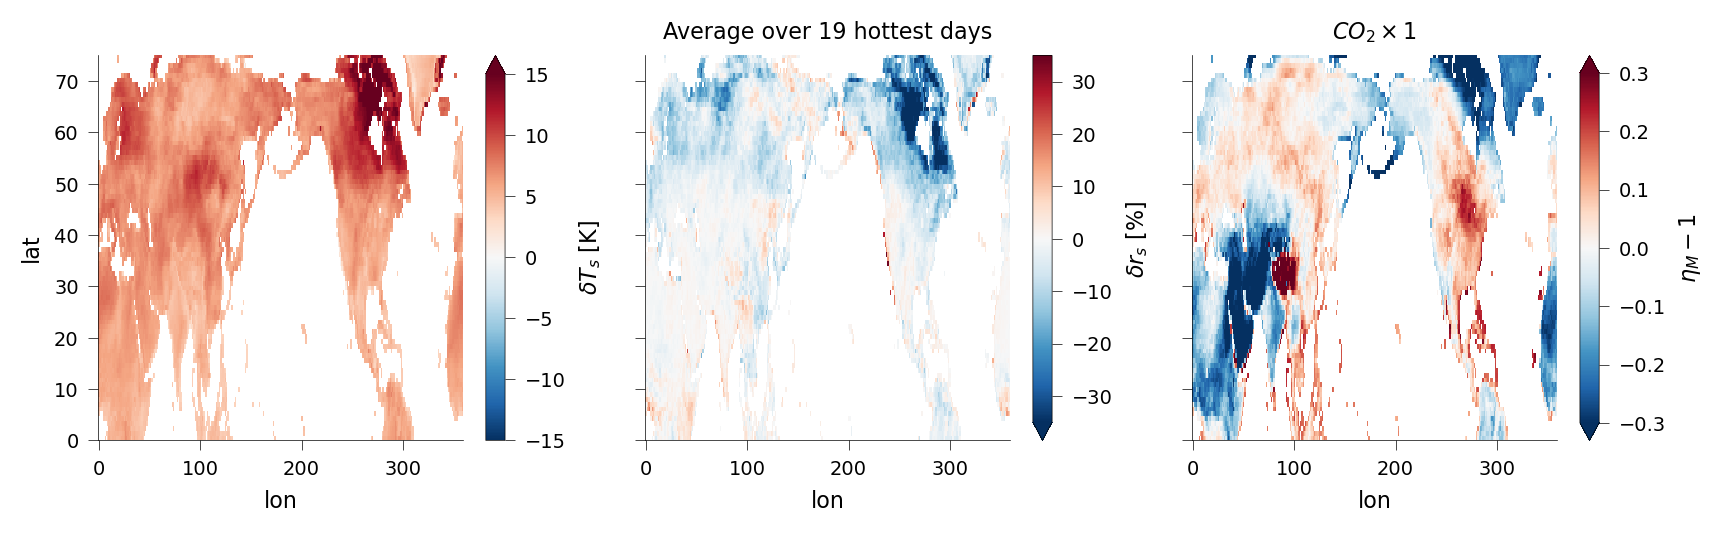

In [18]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
fig_resize(fig, 10)

var = ds.TREFHT
im = (var.isel(co2=1).mean(dim='sample') - var.isel(co2=0).mean(dim='sample')).where(lsm).plot(ax=ax[0], vmax=15)
im.colorbar.set_label('$\delta T_s$ [K]')

var = ds.QREFHT / sphum_sat(ds.TREFHT, ds.PREFHT)
im = (var.isel(co2=1).mean(dim='sample') * 100 - var.isel(co2=0).mean(dim='sample') * 100).where(lsm).plot(ax=ax[1],
                                                                                                           vmin=-35)
im.colorbar.set_label('$\delta r_s$ [%]')

var = ds['lapse_above_env'] / ds['lapse_above_parcel2'] - 1
im = (var.isel(co2=0).mean(dim='sample')).where(lsm).plot(ax=ax[2], vmin=-0.3)
im.colorbar.set_label(f'$\eta_M - 1$')
ax[2].set_title(f'$CO_2 \\times {ds.co2.values[0]:.0f}$')
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[0].set_ylim(0, 75)
ax[1].set_title(f'Average over {ds.sample.size} hottest days')
plt.show()

In [19]:
# ds_use = ds.sel(lat=3, lon=15, method='nearest')         # Congo
# ds_use = ds.sel(lat=-14.6, lon=320, method='nearest')  # Amazon 2
# ds_use = ds.sel(lat=35, lon=100, method='nearest')       # Tibet
# ds_use = ds.sel(lat=55, lon=290, method='nearest')       # Large inversion
# ds_use = ds.sel(lat=-85, lon=100, method='nearest')     # Antarctica
# ds_use = ds.sel(lat=75, lon=320, method='nearest')       # Greenland
ds_use = ds.sel(lat=25, lon=50,method='nearest')        # Pursian gulf
# ds_use = ds.sel(lat=28, lon=50, method='nearest')  # Pursian gulf coastline
# ds_use = ds.sel(lat=18, lon=0, method='nearest')  # Sahara
# ds_use = ds.sel(lat=30, lon=180, method='nearest')  # Ocean
# ds_use = ds.sel(lat=53, lon=100, method='nearest')  # Canada
ds_use = ds_use.isel(co2=0, sample=0)

# High CAPE scenario
# ds_use = ds.sel(lat=50, method='nearest').isel(sample=0)
# lon_ind = ds.CAPE.where(valid_all).sel(lat=float(ds_use.lat)).isel(sample=0).argmax()
# ds_use = ds_use.isel(lon=lon_ind)
# ds_use = ds_use.isel(co2=0)

In [20]:
n_lev_above_ft = 3
def compute_lapse_integral_above_lcl(temp_env_lev, p_lev, temp_env_lcl, p_lcl, p_ft,
                                     temp_env_approx_lev, n_lev_above_ft=n_lev_above_ft):
    # Compute integral of lapse rate and error up to `n_lev_above_ft` model levels above LCL
    if n_lev_above_ft == 0:
        raise ValueError('n_lev_above_ft must be greater than 0')
    if p_lev[1] < p_lev[0]:
        raise ValueError('p_lev[1] must be greater than p_lev[0]')
    ind_upper = np.where(p_lev < p_ft)[0][-n_lev_above_ft]
    lapse_integral = g / R * np.log(temp_env_lev[ind_upper] / temp_env_lcl)
    # lapse_integral = integral_lapse_dlnp_hydrostatic(temp_env_lev, p_lev, p_lcl, p_lev[ind_upper],
    #                                                  temp_env_lcl, temp_env_lev[ind_upper])
    error = integral_lapse_dlnp_hydrostatic(temp_env_lev, p_lev, p_lcl, p_lev[ind_upper],
                                            temp_env_lcl, temp_env_lev[ind_upper], temp_env_approx_lev,
                                            temp_env_lcl, temp_env_approx_lev[ind_upper], take_abs=True)
    return lapse_integral * 1000, error * 1000, ind_upper

In [21]:
T_parcel_use = get_temp_adiabat(np.full(ds.lev.size, float(ds_use.T_lcl_env)),
                                np.full(ds.lev.size, float(sphum_sat(ds_use.T_lcl_env, ds_use.p_lcl))),
                                np.full(ds.lev.size, float(ds_use.p_lcl)), ds_use.P.to_numpy(), epsilon=0)
T_parcel_use_lcl = float(ds_use.T_lcl_env)
T_parcel_use_ft = float(get_temp_adiabat(float(ds_use.T_lcl_env), float(sphum_sat(ds_use.T_lcl_env, ds_use.p_lcl)),
                                         float(ds_use.p_lcl), p_ft, epsilon=0))

key = 'mod_above_lcl'
temp_approx_use = {key: {}}
temp_approx_use[key]['lapse'], temp_approx_use[key]['lapse_integral'], \
    temp_approx_use[key]['lapse_integral_error'] = \
    fitting_2_layer(ds_use.T, ds_use.P.values, float(ds_use.TREFHT), float(ds_use.PREFHT), float(ds_use.T_lcl_env),
                    float(ds_use.p_lcl),
                    float(ds_use.T_ft_env), float(p_ft), method_layer2='mod_parcel', sanity_check=True)
# temp_approx_use[key]['lapse_integral'][0] = g / R * np.log(ds_use.T_lcl_env / ds_use.TREFHT) * 1000   # use analytic below LCL rather than approx
temp_approx_use[key]['temp_lev'] = get_temp_2_layer_approx(ds_use.P.values, float(ds_use.TREFHT), float(ds_use.PREFHT),
                                                           float(ds_use.p_lcl),
                                                           temp_approx_use[key]['lapse'][0] / 1000,
                                                           temp_approx_use[key]['lapse'][1] / 1000,
                                                           method_layer2='mod_parcel')
# temp_approx_use[key]['temp_lev'] = np.where(ds_use.P < ds_use.p_lcl,
#                                             get_temp_mod_parcel_lapse(ds_use.P, ds_use.p_lcl,
#                                                                       temp_approx_use[key]['lapse'][-1] / 1000,
#                                                                       temp_parcel_lev=T_parcel_use),
#                                             get_temp_const_lapse(ds_use.P, ds_use.TREFHT, ds_use.PREFHT,
#                                                                  temp_approx_use[key]['lapse'][0] / 1000))

# Recompute integral up to 3 model levels above p_ft - more robust measure of error
temp_approx_use[key]['lapse_integral'][1], temp_approx_use[key]['lapse_integral_error'][1], p_integ_upper_ind = \
    compute_lapse_integral_above_lcl(ds_use.T.to_numpy(), ds_use.P.to_numpy(), float(ds_use.T_lcl_env),
                                     float(ds_use.p_lcl),
                                     p_ft, temp_approx_use[key]['temp_lev'])

# Get temperature at all model levels as well as LCL and FT.
temp_approx_use['P'], temp_approx_use[key]['temp_lev'] = \
    insert_to_array(ds_use.P.to_numpy(), temp_approx_use[key]['temp_lev'],
                    [float(ds_use.p_lcl), p_ft], [float(ds_use.T_lcl_env), float(ds_use.T_ft_env)])

with np.printoptions(precision=3, suppress=True):
    print(
        f"Lapse Info = {temp_approx_use[key]['lapse']} K/km | "
        f"Error = {temp_approx_use[key]['lapse_integral_error'] / np.abs(temp_approx_use[key]['lapse_integral']) * 100} %")

Actual lapse integral: -6.138 K/km
Approx lapse integral: -6.138 K/km
Actual temp_upper: 265.826 K
Approx temp_upper: 265.826 K
Actual lapse integral: -1.254 K/km
Approx lapse integral: -1.254 K/km
Actual temp_upper: 256.236 K
Approx temp_upper: 256.236 K
Lapse Info = [8.532 0.885] K/km | Error = [12.715 38.356] %


In [22]:
key = 'const_above_lcl'
temp_approx_use[key] = {}
temp_approx_use[key]['lapse'], temp_approx_use[key]['lapse_integral'], \
    temp_approx_use[key]['lapse_integral_error'] = \
    fitting_2_layer(ds_use.T, ds_use.P, float(ds_use.TREFHT), float(ds_use.PREFHT), float(ds_use.T_lcl_env),
                    float(ds_use.p_lcl),
                    float(ds_use.T_ft_env), float(p_ft), sanity_check=True)
# temp_approx_use[key]['lapse_integral'][0] = g / R * np.log(ds_use.T_lcl_env / ds_use.TREFHT) * 1000        # use analytic below LCL rather than approx
temp_approx_use[key]['temp_lev'] = get_temp_2_layer_approx(ds_use.P.values, float(ds_use.TREFHT), float(ds_use.PREFHT),
                                                           float(ds_use.p_lcl),
                                                           temp_approx_use[key]['lapse'][0] / 1000,
                                                           temp_approx_use[key]['lapse'][1] / 1000)
# temp_approx_use[key]['temp_lev'] = np.where(ds_use.P < ds_use.p_lcl,
#                                             get_temp_const_lapse(ds_use.P, ds_use.T_lcl_env, ds_use.p_lcl,
#                                                                  temp_approx_use[key]['lapse'][-1] / 1000),
#                                             get_temp_const_lapse(ds_use.P, ds_use.TREFHT, ds_use.PREFHT,
#                                                                  temp_approx_use[key]['lapse'][0] / 1000))

# Recompute integral up to 3 model levels above p_ft - more robust measure of error
temp_approx_use[key]['lapse_integral'][1], temp_approx_use[key]['lapse_integral_error'][1] = \
    compute_lapse_integral_above_lcl(ds_use.T.to_numpy(), ds_use.P.to_numpy(), float(ds_use.T_lcl_env),
                                     float(ds_use.p_lcl),
                                     p_ft, temp_approx_use[key]['temp_lev'])[:2]

# Get temperature at all model levels as well as LCL and FT.
temp_approx_use[key]['temp_lev'] = \
    insert_to_array(ds_use.P.to_numpy(), temp_approx_use[key]['temp_lev'],
                    [float(ds_use.p_lcl), p_ft], [float(ds_use.T_lcl_env), float(ds_use.T_ft_env)])[1]

with np.printoptions(precision=3, suppress=True):
    print(
        f"Lapse Rate = {temp_approx_use[key]['lapse']} K/km | "
        f"Error = {temp_approx_use[key]['lapse_integral_error'] / np.abs(temp_approx_use[key]['lapse_integral']) * 100} %")

Actual lapse integral: -6.138 K/km
Approx lapse integral: -6.138 K/km
Actual temp_upper: 265.826 K
Approx temp_upper: 265.826 K
Actual lapse integral: -1.254 K/km
Approx lapse integral: -1.254 K/km
Actual temp_upper: 256.236 K
Approx temp_upper: 256.236 K
Lapse Rate = [8.532 7.223] K/km | Error = [12.715 26.213] %


In [23]:
# Loop over range of LCLs, and choose one that gives minimum overall error inintegral
n_lcl_mod = 11
lcl_mod = np.linspace(-0.05, 0.05, n_lcl_mod)
for key in ['const_above_lcl', 'mod_above_lcl']:
    temp_approx_use[f"{key}2"] = {'lapse_integral_error': [np.inf, np.inf]}

for i in range(n_lcl_mod):
    p_lcl_use = float(10 ** (np.log10(ds_use.p_lcl) + lcl_mod[i]))
    if p_lcl_use >= ds_use.PREFHT:
        continue
    if p_lcl_use <= p_ft:
        continue
    T_lcl_env_use = float(get_var_at_plev(ds_use.T, ds_use.P, p_lcl_use))
    key = 'const_above_lcl2'
    output_i = fitting_2_layer(ds_use.T, ds_use.P, float(ds_use.TREFHT), float(ds_use.PREFHT),
                               T_lcl_env_use, p_lcl_use, float(ds_use.T_ft_env), float(p_ft),
                               sanity_check=False)

    # Recompute integral up to 3 model levels above p_ft - more robust measure of error
    temp_lev_approx_use = get_temp_2_layer_approx(ds_use.P.values, float(ds_use.TREFHT), float(ds_use.PREFHT),
                                                  p_lcl_use, output_i[0][0] / 1000, output_i[0][1] / 1000)
    output_i[1][-1], output_i[2][-1] = \
        compute_lapse_integral_above_lcl(ds_use.T.to_numpy(), ds_use.P.to_numpy(), T_lcl_env_use, p_lcl_use,
                                         p_ft, temp_lev_approx_use)[:2]

    if np.sum(output_i[2]) < np.sum(temp_approx_use[key]['lapse_integral_error']):
        temp_approx_use[key]['lapse'], temp_approx_use[key]['lapse_integral'], \
            temp_approx_use[key]['lapse_integral_error'] = output_i
        temp_approx_use[key]['p_lcl'] = p_lcl_use
        temp_approx_use[key]['T_lcl_env'] = T_lcl_env_use
        temp_approx_use[key]['temp_lev'] = temp_lev_approx_use
        # temp_approx_use[key]['temp_lev'] = np.where(ds_use.P < p_lcl_use,
        #                                             get_temp_const_lapse(ds_use.P, T_lcl_env_use, p_lcl_use,
        #                                                                  temp_approx_use[key]['lapse'][-1] / 1000),
        #                                             get_temp_const_lapse(ds_use.P, ds_use.TREFHT, ds_use.PREFHT,
        #                                                                  temp_approx_use[key]['lapse'][0] / 1000))

    key = 'mod_above_lcl2'
    T_parcel_use = get_temp_adiabat(np.full(ds.lev.size, T_lcl_env_use),
                                    np.full(ds.lev.size, float(sphum_sat(T_lcl_env_use, p_lcl_use))),
                                    np.full(ds.lev.size, p_lcl_use), ds_use.P.to_numpy(), epsilon=0)
    T_parcel_use_ft = float(get_temp_adiabat(T_lcl_env_use, float(sphum_sat(T_lcl_env_use, p_lcl_use)),
                                             p_lcl_use, p_ft, epsilon=0))
    output_i = fitting_2_layer(ds_use.T.values, ds_use.P.values, float(ds_use.TREFHT), float(ds_use.PREFHT), T_lcl_env_use,
                               p_lcl_use, float(ds_use.T_ft_env), p_ft, method_layer2='mod_parcel', sanity_check=False)

    # Recompute integral up to 3 model levels above p_ft - more robust measure of error
    temp_lev_approx_use = get_temp_2_layer_approx(ds_use.P.values, float(ds_use.TREFHT), float(ds_use.PREFHT),
                                                  p_lcl_use,
                                                  output_i[0][0] / 1000,
                                                  output_i[0][1] / 1000,
                                                  method_layer2='mod_parcel')
    output_i[1][-1], output_i[2][-1] = \
        compute_lapse_integral_above_lcl(ds_use.T.to_numpy(), ds_use.P.to_numpy(), T_lcl_env_use, p_lcl_use,
                                         p_ft, temp_lev_approx_use)[:2]

    if np.sum(output_i[2]) < np.sum(temp_approx_use[key]['lapse_integral_error']):
        temp_approx_use[key]['lapse'], temp_approx_use[key]['lapse_integral'], \
            temp_approx_use[key]['lapse_integral_error'] = output_i
        temp_approx_use[key]['p_lcl'] = p_lcl_use
        temp_approx_use[key]['T_lcl_env'] = T_lcl_env_use
        temp_approx_use[key]['temp_lev'] = temp_lev_approx_use

# Get temperature at all model levels as well as PHYSICAL LCL and FT.
for key in ['const_above_lcl2', 'mod_above_lcl2']:
    T_lcl_env_use = float(get_var_at_plev(temp_approx_use[key]['temp_lev'], ds_use.P, ds_use.p_lcl))
    temp_approx_use[key]['temp_lev'] = \
        insert_to_array(ds_use.P.to_numpy(), temp_approx_use[key]['temp_lev'],
                        [float(ds_use.p_lcl), p_ft], [T_lcl_env_use, float(ds_use.T_ft_env)])[1]
    with np.printoptions(precision=3, suppress=True):
        print(
            f"{key} | LCL Diff = {(float(ds_use.p_lcl - temp_approx_use[key]['p_lcl']) / 100):.0f} hPa | Lapse Rate = {temp_approx_use[key]['lapse']} K/km | Error = {temp_approx_use[key]['lapse_integral_error']} K/km")

const_above_lcl2 | LCL Diff = -46 hPa | Lapse Rate = [8.985 6.606] K/km | Error = [0.334 0.926] K/km
mod_above_lcl2 | LCL Diff = -46 hPa | Lapse Rate = [8.985 0.438] K/km | Error = [0.334 1.373] K/km


In [24]:
# Sanity check that value of the integral is the same for all methods
for key in temp_approx_use:
    if key == 'P':
        continue
    print(f"{key} | Integral value = {np.sum(temp_approx_use[key]['lapse_integral']):.3f} K/km")

mod_above_lcl | Integral value = -9.686 K/km
const_above_lcl | Integral value = -9.686 K/km
const_above_lcl2 | Integral value = -9.686 K/km
mod_above_lcl2 | Integral value = -9.686 K/km


In [25]:
temp_approx_use['const_above_lcl']['lapse_integral_error']

array([0.78044151, 0.93005829])

### Example Plot
Below I show several possible naive fits to the environmental temperature profile, in order to explain why $\epsilon \neq 0$ i.e. why it is not convectively neutral.

In the plot below, I include in the legend some dimensionless parameters:
* $\eta_{D}$: The approx environmental lapse rate below the LCL is given by $\Gamma_{<LCL | env}(p) \approx \eta_{D} \Gamma_D$
* $\eta_{M}$ for `const_above_lcl`: The approx environmental lapse rate above the LCL is given by $\Gamma_{>LCL | env}(p) \approx \eta_{M} \Gamma_D$
* $\eta_{M}$ for `mod_above_lcl`: The approx environmental lapse rate above the LCL is given by $\Gamma_{>LCL | env}(p) \approx \Gamma_{>LCL | parcel}(p) + \eta_{M} \Gamma_D$. Note in this case approx lapse rate varies with pressure.
* $\eta_{LCL}$: The empirical LCL to minimise integral $\int_{p_s}^{p_{FT}} |\Gamma_{env}(p) - \Gamma_{approx | env}(p)| d\ln p$ is $p_{LCL | best} = \eta_{LCL} p_{LCL | phys}$

The $\%$ error given below is equal to $\int_{p_s}^{p_{up}} |\Gamma_{env}(p) - \Gamma_{approx | env}(p)| d\ln p$ / $|\int_{p_s}^{p_{up}} \Gamma_{env}(p) d\ln p|$. Note the denomenator is the same for all estimates of $\Gamma_{approx | env}(p)$.

Where $p_{up}$ (black cross below) is the model level 3 levels higher than $p_{FT}$. Choose this rather than $p_{FT}$ to give more robust measure of error.

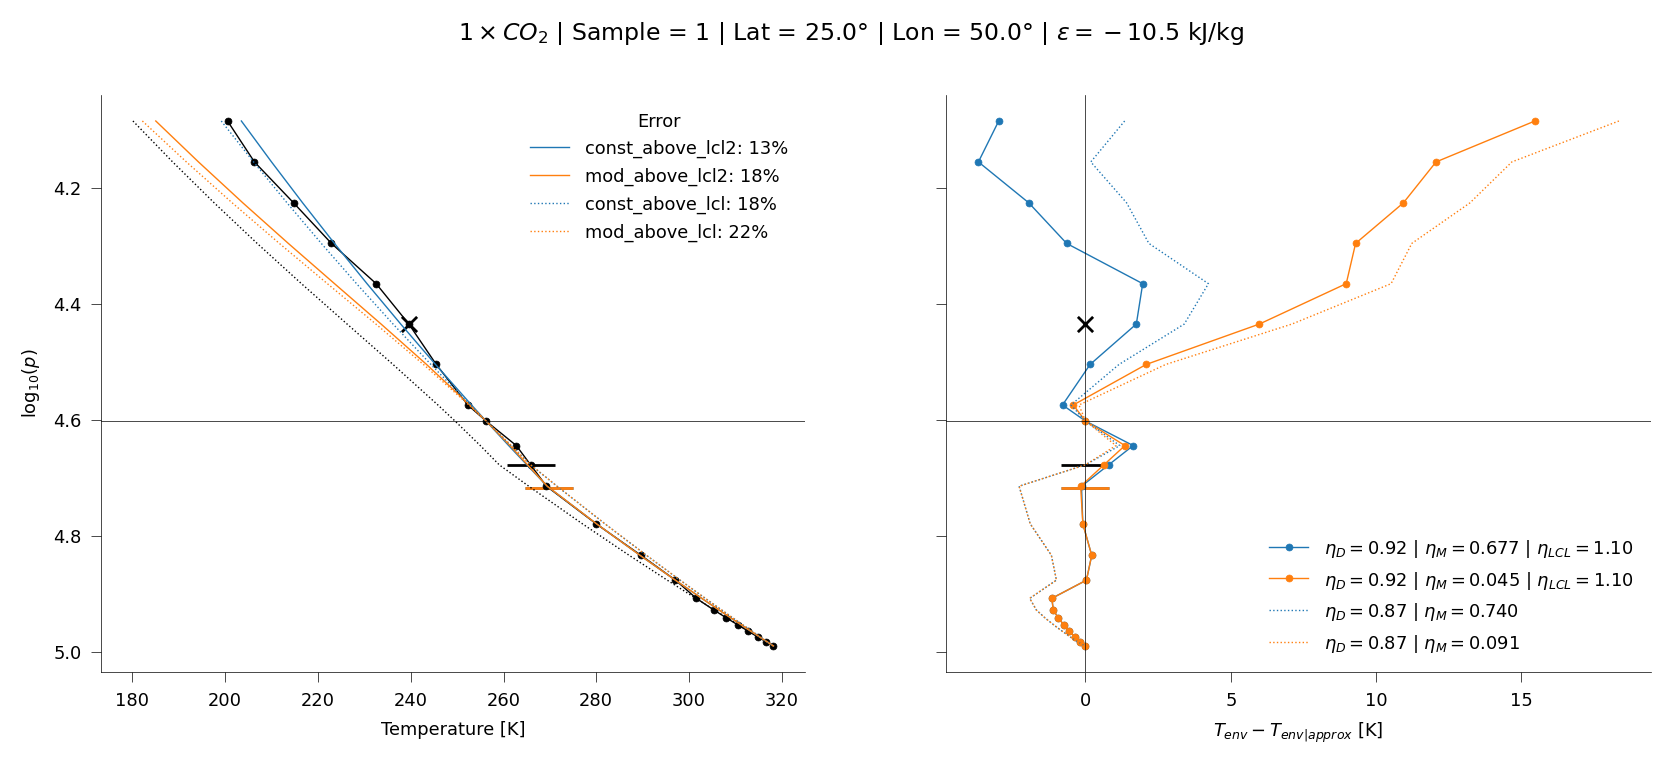

In [26]:
p_thresh = float(ds_use.P.isel(lev=ds_use.lnb_ind) - 1)
# p_thresh = 300 * 100
use_lev = temp_approx_use['P'] >= p_thresh

show_phys_lcl = True
show_lcl_markers = True
fig, ax = plt.subplots(1, 2, sharey=True)
fig_resize(fig, 10)
temp_env_use = insert_to_array(ds_use.P.to_numpy(), ds_use.T.to_numpy(),
                               [float(ds_use.p_lcl), p_ft], [float(ds_use.T_lcl_env), float(ds_use.T_ft_env)])[1]
ax[0].plot(temp_env_use[use_lev], np.log10(temp_approx_use['P'])[use_lev], color='k', marker='o')

T_parcel_use = convection_neutral_profile(float(ds_use.TREFHT), float(ds_use.PREFHT), float(ds_use.T_lcl_parcel),
                                          temp_approx_use['P'])
ax[0].plot(T_parcel_use[use_lev], np.log10(temp_approx_use['P'])[use_lev], color='k', linestyle=':')

for i, key in enumerate(['const_above_lcl2', 'mod_above_lcl2']):
    label_use = f'{key}: {np.abs(np.sum(temp_approx_use[key]["lapse_integral_error"]) / np.sum(temp_approx_use[key]["lapse_integral"]) * 100):.0f}%'
    ax[0].plot(temp_approx_use[key]['temp_lev'][use_lev], np.log10(temp_approx_use['P'])[use_lev], color=f'C{i}',
               label=label_use)
    label_use = (f"$\eta_{'{D}'} = {temp_approx_use[key]['lapse'][0] / lapse_dry / 1000:.2f}$ | "
                 f"$\eta_{'{M}'} = {temp_approx_use[key]['lapse'][1] / lapse_dry / 1000:.3f}$ | "
                 f"$\eta_{'{LCL}'} = {temp_approx_use[key]['p_lcl'] / ds_use.p_lcl:.2f}$")
    ax[1].plot((temp_env_use - temp_approx_use[key]['temp_lev'])[use_lev], np.log10(temp_approx_use['P'])[use_lev],
               color=f'C{i}', marker='o', label=label_use)

if show_phys_lcl:
    for i, key in enumerate(['const_above_lcl', 'mod_above_lcl']):
        label_use = f'{key}: {np.abs(np.sum(temp_approx_use[key]["lapse_integral_error"]) / np.sum(temp_approx_use[key]["lapse_integral"]) * 100):.0f}%'
        ax[0].plot(temp_approx_use[key]['temp_lev'][use_lev], np.log10(temp_approx_use['P'])[use_lev], color=f'C{i}',
                   linestyle=':', label=label_use)
        label_use = (f"$\eta_{'{D}'} = {temp_approx_use[key]['lapse'][0] / lapse_dry / 1000:.2f}$ | "
                     f"$\eta_{'{M}'} = {temp_approx_use[key]['lapse'][1] / lapse_dry / 1000:.3f}$")
        ax[1].plot((temp_env_use - temp_approx_use[key]['temp_lev'])[use_lev], np.log10(temp_approx_use['P'])[use_lev],
                   color=f'C{i}', linestyle=':', label=label_use)

if show_lcl_markers:
    ax[0].scatter(ds_use.T_lcl_env, np.log10(ds_use.p_lcl), marker='_', s=300, color='k', lw=1)
    ax[1].scatter(0, np.log10(ds_use.p_lcl), marker='_', s=300, color='k', lw=1)
    for i, key in enumerate(['const_above_lcl2', 'mod_above_lcl2']):
        ax[0].scatter(temp_approx_use[key]['T_lcl_env'], np.log10(temp_approx_use[key]['p_lcl']), marker='_', s=300,
                      color=f'C{i}', lw=1)
        ax[1].scatter(0, np.log10(temp_approx_use[key]['p_lcl']), marker='_', s=300, color=f'C{i}', lw=1)

# ax[1].plot((temp_env_use - temp_approx_use[f"{key}2"]['temp_lev'])[use_lev], np.log10(temp_approx_use['P'])[use_lev],
#            color=f'C{i}')
# ax[0].set_ylim(4.6, 5)
ax[1].axvline(0, color='k', lw=ax_linewidth)
ax[0].invert_yaxis()
ax[0].legend(title='Error')
ax[1].legend()
ax[0].set_ylabel('$\log_{10}(p)$')
ax[0].set_xlabel('Temperature [K]')
ax[1].set_xlabel('$T_{env} - T_{env | approx}$ [K]')

ax[0].axhline(np.log10(p_ft), color='k', lw=ax_linewidth)
ax[0].scatter(ds_use.T[p_integ_upper_ind], np.log10(ds_use.P[p_integ_upper_ind]), color='k', marker='x', s=30, lw=1)
ax[1].axhline(np.log10(p_ft), color='k', lw=ax_linewidth)
ax[1].scatter(0, np.log10(ds_use.P[p_integ_upper_ind]), color='k', marker='x', s=30, lw=1)

# update_linewidth(fig)
update_fontsize(fig, 4.5)
fig.suptitle(
    f"${int(ds_use.co2)} \\times CO_2$ | Sample = {int(ds_use.sample)} | Lat = {ds_use.lat:.1f}$\degree$ | Lon = {ds_use.lon:.1f}$\degree$ | "
    f"$\epsilon = {float(ds_use.mse_REFHT - ds_use.mse_ft_env_sat):.1f}$ kJ/kg",
    fontsize=8.5)
plt.show()

In [27]:
# Sanity check that get the same results above as with functions from isca_tools functions
p_lcl_use = [(10 ** (np.log10(ds_use.p_lcl) + lcl_mod[i])) for i in range(n_lcl_mod)]
ds_use['p_lcl_mod'] = xr.concat(p_lcl_use, dim=xr.DataArray(lcl_mod, name='lcl_mod', dims='lcl_mod'))
ds_use['T_lcl_env_mod'] = get_var_at_plev(ds_use.T, ds_use.P, ds_use.p_lcl_mod)
var = {}
for key in ['const', 'mod_parcel']:
    key2 = 'const_above_lcl2' if key == 'const' else 'mod_above_lcl2'
    var = fitting_2_layer_xr(ds_use.T, ds_use.P, ds_use.TREFHT, ds_use.PREFHT, ds_use.T_lcl_env_mod, ds_use.p_lcl_mod, ds_use.T_ft_env,
                             p_ft, n_lev_above_upper2_integral=n_lev_above_ft,
                             method_layer2=key)
    ind_best = var[2].sum(dim='layer').argmin(dim='lcl_mod')
    var = [x.isel(lcl_mod=ind_best).squeeze() for x in var]
    print('Method 1 Lapse', temp_approx_use[key2]['lapse'], 'K/km')
    print('Method 2 Lapse', var[0].values, 'K/km')
    # print('Method 1', temp_approx_use[key2]['lapse'])
    print(f'Method 1 Error {np.abs(np.sum(temp_approx_use[key2]["lapse_integral_error"])/np.sum(temp_approx_use[key2]["lapse_integral"])*100):.4f} %')
    print(f'Method 2 Error {np.abs(var[2].sum(dim="layer")/var[1].sum(dim="layer")*100):.4f} %')
    # print('Method 2 Error', float(var[2].sum(dim='layer')))
    # print(temp_approx_use[key2]['p_lcl'])
    # print(ds_use.p_lcl_mod)

Method 1 Lapse [8.98534418 6.60574196] K/km
Method 2 Lapse [8.98534418 6.60574196] K/km
Method 1 Error 13.0113 %
Method 2 Error 13.0113 %
Method 1 Lapse [8.98534418 0.43805509] K/km
Method 2 Lapse [8.98534418 0.43805509] K/km
Method 1 Error 17.6238 %
Method 2 Error 17.6238 %


In [154]:
ds_use = ds.isel(co2=0, lat=slice(0, 50), lon=0)
var = fitting_2_layer_xr(ds_use.T, ds_use.P, ds_use.TREFHT, ds_use.PREFHT, ds_use.T_lcl_env, ds_use.p_lcl, ds_use.T_ft_env,
                         p_ft, n_lev_above_upper2_integral=n_lev_above_ft,
                         method_layer2='mod_parcel')

In [87]:
var = fitting_2_layer_xr(ds_use.T, ds_use.P, ds_use.TREFHT, ds_use.PREFHT, ds_use.T_lcl_env, ds_use.p_lcl, ds_use.T_ft_env,
                         p_ft, n_lev_above_upper2_integral=n_lev_above_ft,
                         method_layer2='const')